# Read the characters in clothes using OCR

OCR을 통해 옷에 적혀있는 글씨를 읽을 수 있는 지 알아보기 위해 데이터셋을 준비합니다. 간단하게 3장 정도로만 테스트를 해보겠습니다.

## 0. 데이터셋 준비

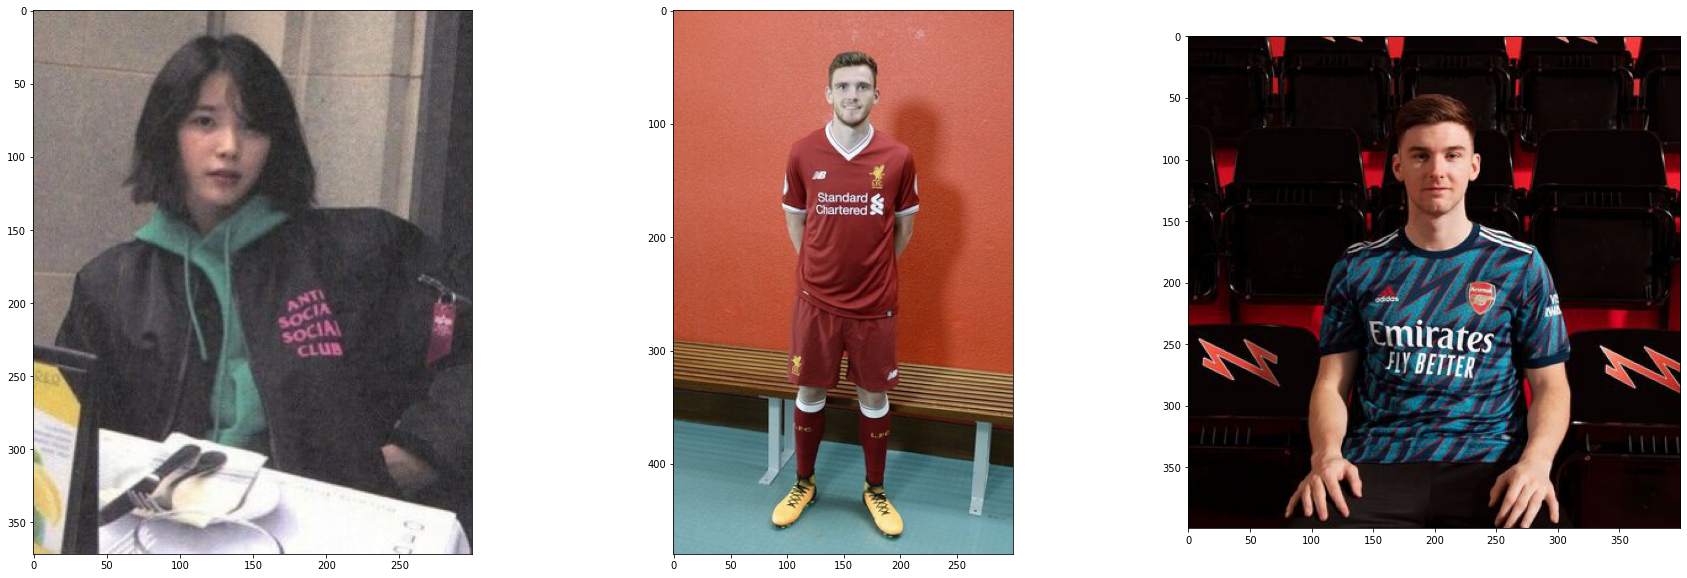

In [93]:
image_files = sorted(glob.glob('./data/*.jpg'))

from PIL import Image

images = [Image.open(file) for file in image_files]

fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize=(30, 10))
axs = axes.ravel()

for idx, image in enumerate(images):
    axs[idx].imshow(image)

먼저 노드에 나왔던 방법을 하나씩 수행하면서 단어를 잘 찾아내는 지 알아보겠습니다.

## 1. Google Cloud Vision API

In [94]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [96]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'


# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for file in image_files:
    detect_text(file)
    print('*' * 25)

-rw-r--r-- 1 root root 2333 Sep 14 04:47 /aiffel/aiffel/ocr_python/my_google_api_key.json
Texts:

"ANTI
SOCIA
SOCIAI
CLUB
"

"ANTI"

"SOCIA"

"SOCIAI"

"CLUB"
bounds: (181,229),(209,226),(210,234),(182,237)
*************************
Texts:

"Standards
Chartered:
"

"Standards"

"Chartered:"
bounds: (124,170),(173,170),(173,182),(124,182)
*************************
Texts:

"ద
Emirates
FLY BETTER
"

"ద"

"Emirates"

"FLY"

"BETTER"
bounds: (185,257),(232,259),(231,277),(184,275)
*************************


## 2. Keras-OCR

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


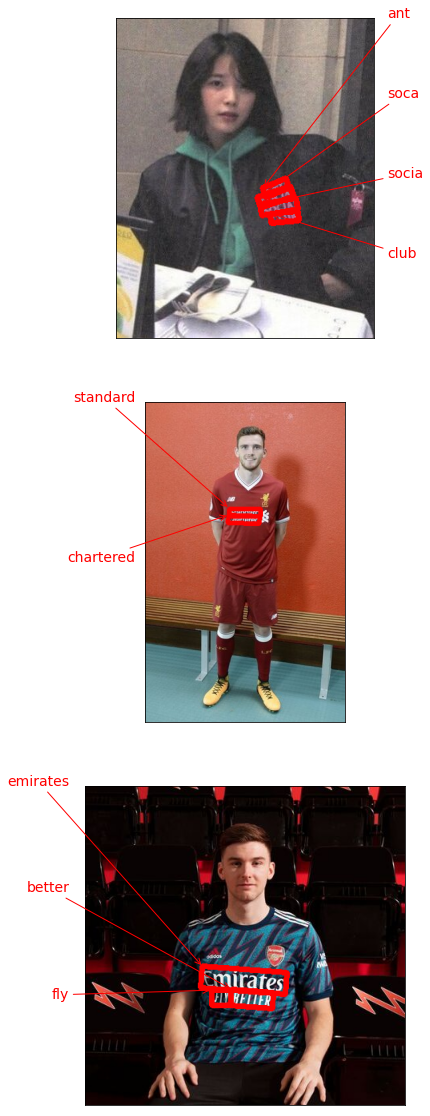

In [105]:
import glob
import keras_ocr
import matplotlib.pyplot as plt

from functools import reduce
# 상대경로를 사용했다. 환경에 맞춰 경로를 변경해야한다.
#from popEval import process, make_pair, _divide


pipeline = keras_ocr.pipeline.Pipeline()

image_files = sorted(glob.glob('data/img*.jpg'))
images = [keras_ocr.tools.read(path) for path in image_files]
prediction_groups = [pipeline.recognize([path]) for path in image_files]


# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## 3. Tesseract

In [86]:
import os
import pytesseract ## Python tesseract wrapper 
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)
    
    recognized_data = pytesseract.image_to_data(
        image, lang='eng',
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
        
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [87]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
        
    print("Done")

In [122]:
work_dir = os.getenv('HOME') + '/aiffel/exploration-18-OCR/data'
img_file_path = work_dir + '/img0001.jpg'

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)


/aiffel/aiffel/exploration-18-OCR/data/0000.png


In [123]:
recognize_images(cropped_image_path_list)

ay

Done


### 짧은 소감

우선 노드 제출일을 착각해 뒤늦게 하느라 완벽하게 못했습니다. 아지트에 올려주신 신관수님의 팁대로 해보려했지만 시간이 오래 걸리고 수행하지 못했습니다. 짧게나마 OCR에 대해 알 수 있어 좋았고, 다양한 라이브러리를 써볼 수 있는 기회였습니다.